In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, UpSampling2D, Dense, MaxPool2D, LeakyReLU, Reshape, Dropout, Flatten, GaussianNoise
from tensorflow.keras.losses import BinaryCrossentropy, MSE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
import tensorflow.keras.backend as K
import tensorflow as tf


import numpy as np
import scipy
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import time

In [2]:
def normalize_img(img):
    return (img - 127.5)/127.5

def unnormalize_img(img):
    return (img + 1.) / 2.

In [3]:
train_imgs = []
import os
for root, dirs, files in os.walk("./CUB_200_2011/CUB_200_2011/images-cleaned/", topdown=False):
    for name in files:
        im = cv2.cvtColor(cv2.imread(os.path.join(root, name)), cv2.COLOR_RGB2BGR)
        im = cv2.resize(im, (75, 75))
        train_imgs.append(im)

train_imgs = np.array(train_imgs)
train_imgs = (train_imgs - 127.5)/127.5

In [4]:
def make_generator_model_mse(shape):
    
    input_layer = Input(shape=shape)
    
    x = Dense(8*8*64)(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Reshape((8, 8, 64))(x)
    
    x = Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)
    
    return Model(input_layer, x)

In [5]:
def make_generator_model_deeper(shape):
    
    input_layer = Input(shape=shape)
    
    x = Dense(16*16*64)(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Reshape((16, 16, 64))(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(32, (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(16, (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(3, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh')(x)
    
    return Model(input_layer, x)

In [6]:
def make_generator_model_balanced(shape):
    
    input_layer = Input(shape=shape)
    
    x = Dense(16*16*64*2)(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Reshape((16, 16, 128))(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(32, (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(16, (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(3, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh')(x)
    
    return Model(input_layer, x)

In [7]:
deeper_g_200z = make_generator_model_deeper(200)
deeper_g_100z = make_generator_model_deeper(100)
mse_g = make_generator_model_mse(200)
balanced_g = make_generator_model_balanced(100)

In [8]:
deeper_g_200z.load_weights('./results/weights/bird-gan-deeper/gen_weights_deeper_4000.h5')
deeper_g_100z.load_weights('./results/weights/bird-gan-deeper-smaller-z/gen_weights_deeper_smaller_z_4000.h5')
mse_g.load_weights('./results/weights/bird-gan-mse/gen_weights_mse_3900.h5')
balanced_g.load_weights('./results/weights/bird-gan-deeper-smaller-z-balanced/gen_weights_deeper_smaller_z_balanced_4000.h5')

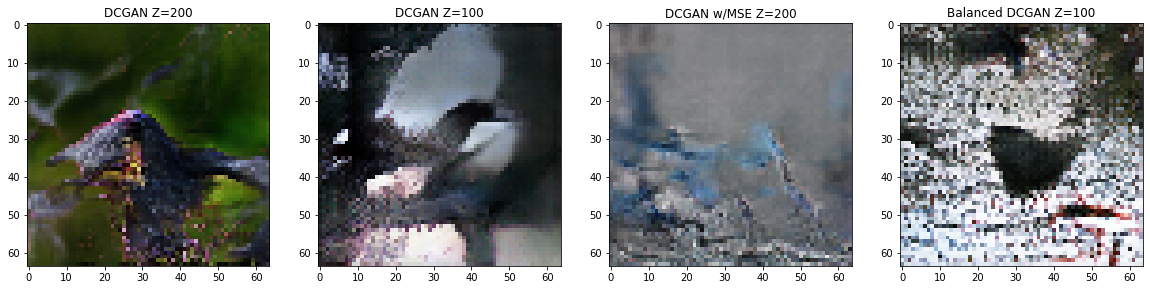

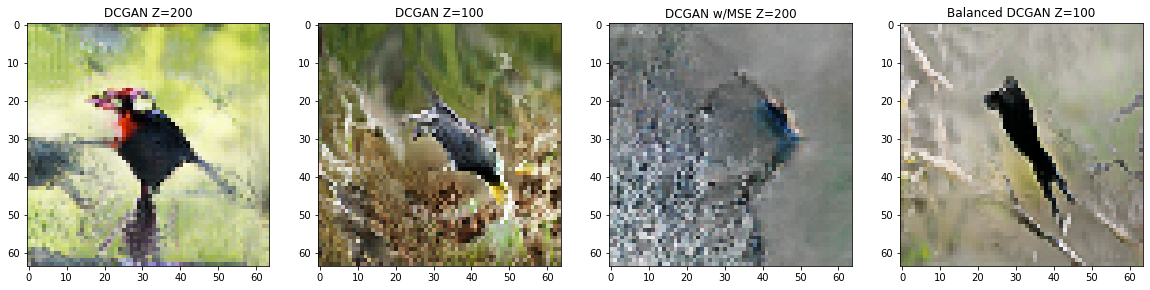

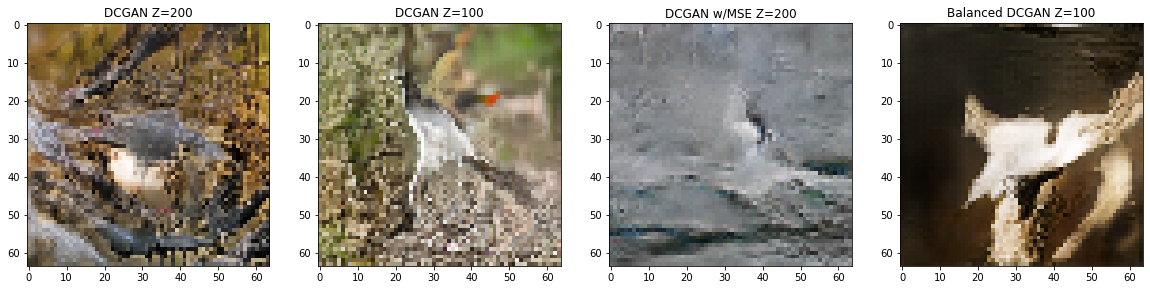

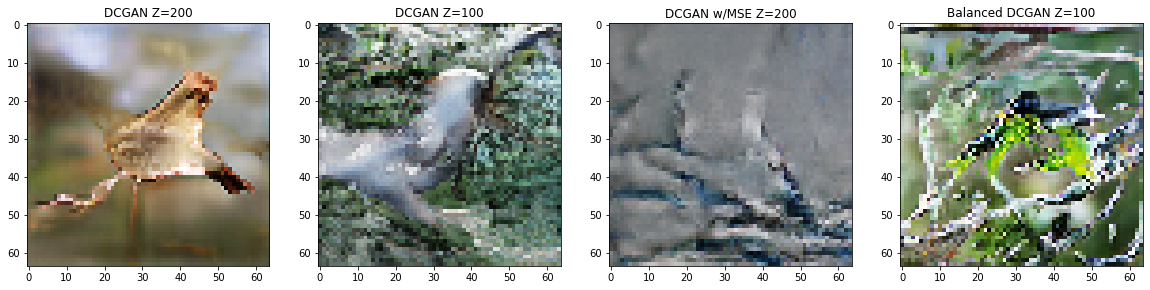

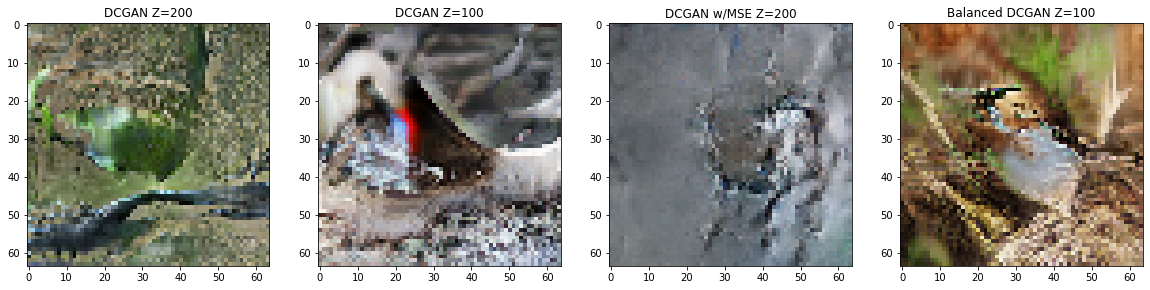

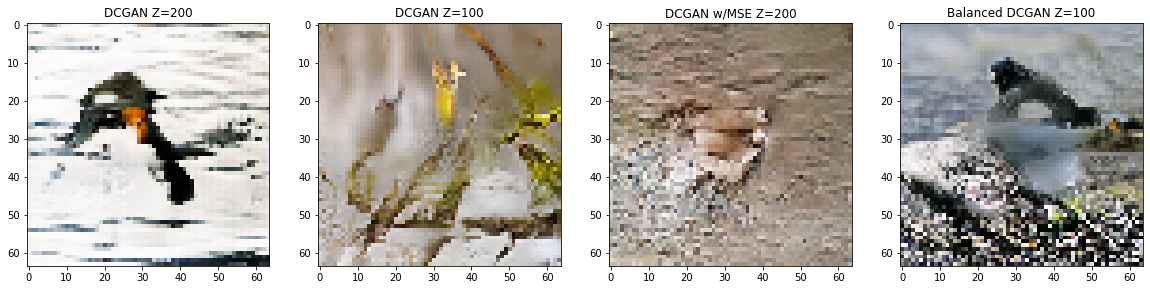

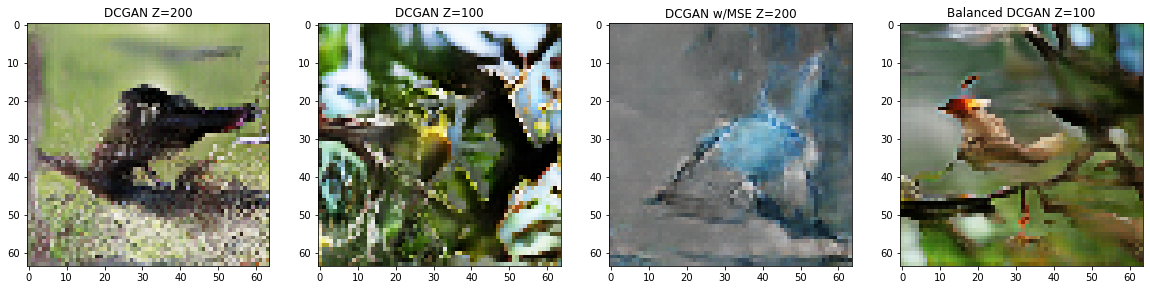

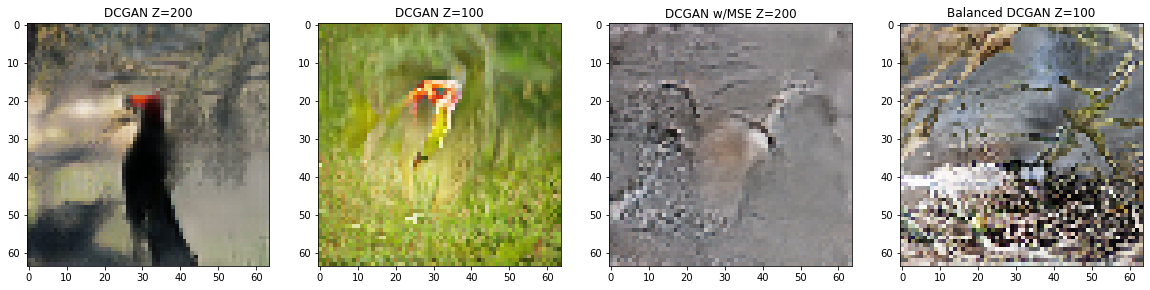

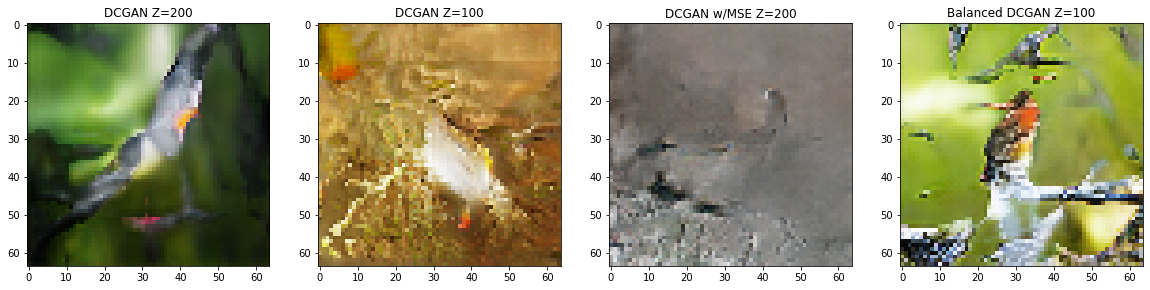

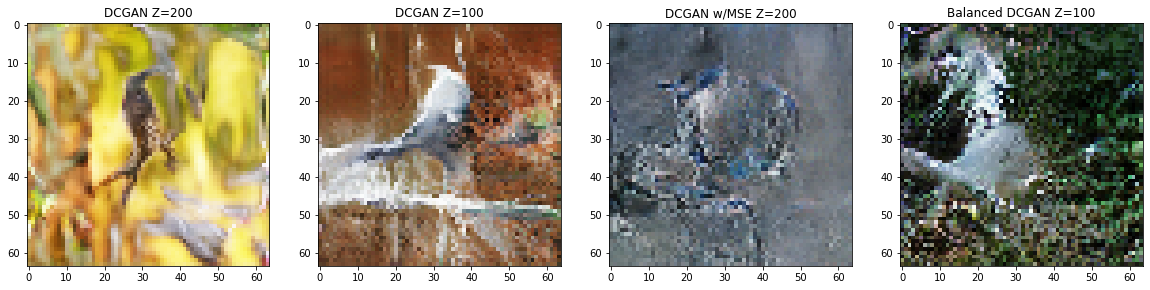

In [32]:
for i in range(10):
    noise200 = np.random.normal(0, 1, 200)
    noise100 = noise200[:100]
    
    deeper_image_200z = deeper_g_200z.predict(np.array([noise200]))[0]
    deeper_image_100z = deeper_g_100z.predict(np.array([noise100]))[0]
    mse_image = mse_g.predict(np.array([noise200]))[0]
    balanced_image = balanced_g.predict(np.array([noise100]))[0]
    
    fig = plt.figure(figsize=(20,20))
    ax1 = fig.add_subplot(141)
    ax1.imshow(unnormalize_img(deeper_image_200z))
    ax2 = fig.add_subplot(142)
    ax2.imshow(unnormalize_img(deeper_image_100z))
    ax3 = fig.add_subplot(143)
    ax3.imshow(unnormalize_img(mse_image))
    ax4 = fig.add_subplot(144)
    ax4.imshow(unnormalize_img(balanced_image))
    ax1.title.set_text('DCGAN Z=200')
    ax2.title.set_text('DCGAN Z=100')
    ax3.title.set_text('DCGAN w/MSE Z=200')
    ax4.title.set_text('Balanced DCGAN Z=100')
    plt.show()

In [10]:
def generate_fake_images(model, samples, noise_dim):
    noise = np.random.normal(0, 1, (samples, noise_dim))
    imgs = model.predict(noise)
    resized_imgs = []
    for img in imgs:
        resized_imgs.append(cv2.resize(img, (75, 75)))
    return np.array(resized_imgs)

In [11]:
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = scipy.linalg.sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [13]:
# iv3 = create_upsampling_iv3()
iv3 = InceptionV3(include_top=False, pooling='avg', input_shape=(75,75,3))

In [14]:
# np.random.shuffle(train_imgs)
real_images = train_imgs

In [15]:
fake_images = generate_fake_images(deeper_g_200z, len(real_images), 200)

In [16]:
fid = calculate_fid(iv3, real_images, fake_images)

KeyboardInterrupt: 

In [ ]:
# For Z = 200
fids = 0
for i in range(5):
    fake_images = generate_fake_images(deeper_g_200z, len(real_images), 200)
    fids += calculate_fid(iv3, real_images, fake_images)
    print(fids / (i + 1.))
print(fids/5.)

In [ ]:
# For Z = 100
fids = 0
for i in range(5):
    fake_images = generate_fake_images(deeper_g_100z, len(real_images), 100)
    fids += calculate_fid(iv3, real_images, fake_images)
    print(fids / (i + 1.))
print(fids/5.)

In [17]:
# For Z = 100 Balanced
fids = 0
for i in range(5):
    fake_images = generate_fake_images(balanced_g, len(real_images), 100)
    fids += calculate_fid(iv3, real_images, fake_images)
    print(fids / (i + 1.))
print(fids/5.)

190.1219035116974
187.6991569401627
188.55692068276372
189.15526006722212
189.09130090761573
189.09130090761573
